**Ссылка на PyPi модуль:** https://pypi.org/project/fin-art/



**Исходник:**

In [ ]:
import warnings
# Отключаем предупреждения
warnings.filterwarnings("ignore")

# Отключаем логи для библиотеки transformers
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

# Отключаем логи для библиотеки diffusers
from diffusers import logging as diffusers_logging
diffusers_logging.set_verbosity_error()

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

class ImageGenerator:
    LORA_PATHS = {
        "pixel": "madvasik/pixel-art-lora",
        "ink": "madvasik/ink-art-lora",
        "cyberpunk": "madvasik/cyberpunk-lora",
        "lego": "madvasik/lego-lora",
        "glasssculpture": "madvasik/glasssculpture-lora"
    }

    # базовый негатив промпт
    base_negative = "deformed eyes, low quality, low res, blurry, distortion, cropped, jpeg artifacts, duplicate, ugly, bad anatomy, bad proportions, deformed, malformed, off-screen, low resolution, unattractive, unnatural pose"
    # базовые промпты для лор
    base_lora_prompts = {
        "pixel": "pixel, ",
        "ink": "white background, scenery, ink, ",
        "cyberpunk": "CyberpunkAI, ",
        "lego": "LEGO Creator, ",
        "glasssculpture": "glasssculpture, transparent, translucent, reflections, "
    }

    def __init__(self, model_name='k1tub/gpt2_prompts',
                 tokenizer_name='distilbert/distilgpt2',
                 stable_diff_model='stable-diffusion-v1-5/stable-diffusion-v1-5',
                 lora_type='pixel',
                 device='cuda'):
        self.device = device

        if lora_type is not None and lora_type not in self.LORA_PATHS:
            raise ValueError(f"Invalid LoRA type: {lora_type}. Choose from {list(self.LORA_PATHS.keys())} or None to skip.")

        # GPT и токенизатор
        self.tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token  # Устанавливаем pad_token как eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

        # пайплайн Stable Diffusion
        self.text2img_pipe = StableDiffusionPipeline.from_pretrained(
            stable_diff_model, torch_dtype=torch.float16,
            safety_checker = None, requires_safety_checker = False).to(device)

        # Загружаем LoRA
        if lora_type is not None:
            self.load_lora_weights(lora_type)
            # триггер слова для лоры
            self.base_prompt = self.base_lora_prompts[lora_type]
        else:
          self.base_prompt = ''

    def translate_prompt(self, init_prompt):
        """Переводит промпт на английский"""
        result = GoogleTranslator(source='auto', target='en').translate(init_prompt)
        return result

    def load_lora_weights(self, lora_type):
        """Загружает LoRA веса на основе выбранного типа."""
        lora_path = self.LORA_PATHS[lora_type]
        print(f"Loading LoRA weights: {lora_path}")
        self.text2img_pipe.load_lora_weights(lora_path)


    def improve_with_gpt(self, input_prompt, n_prompts):
        """Улучшает входной промт с помощью GPT-2."""
        input_ids = self.tokenizer.encode(input_prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones(input_ids.shape, device=self.device)

        outs = self.model.generate(
            input_ids, attention_mask=attention_mask,
            num_beams=n_prompts, top_p=0.9,
            max_length=70, num_return_sequences=n_prompts,
            pad_token_id=self.tokenizer.eos_token_id
        )


        improved_prompts = [self.tokenizer.decode(out, skip_special_tokens=True).replace('\n', '') for out in outs]

        return improved_prompts

    def generate_images(self, input_prompt, num_images=1, num_inference_steps=50,
                        show_prompt=False, improve_prompt=False, negative_prompt=base_negative, translate=True, plot=True):
        """Генерирует изображения на основе текста, с возможным улучшением промта."""

        # переводим если надо
        if translate:
          input_prompt = self.translate_prompt(input_prompt)


        # Улучшаем промпт (если improve_prompt=True)
        if improve_prompt:
            prompts = self.improve_with_gpt(input_prompt, num_images)
        else:
            prompts = [input_prompt] * num_images
        # Генерация изображений
        images = []
        for prompt in prompts:
            image = self.text2img_pipe(self.base_prompt + prompt, num_inference_steps=num_inference_steps, negative_prompt=negative_prompt).images[0]
            images.append((image, prompt))

        if plot:
          for img, prompt in images:
              if show_prompt:
                  print(f"Final prompt: {self.base_prompt + prompt}")
              plt.figure(figsize=(6, 6))
              plt.imshow(img)
              plt.axis("off")
              plt.show()
        else:
          return images

**Использование модуля**

In [ ]:
!pip install fin-art==7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 25.6 MB/s eta 0:00:00


In [ ]:
from fin_art import ImageGenerator

**Атрибуты класса по умолчанию (можно не прописывать)**
*  `model_name`="k1tub/gpt2_prompts" (поменяем на нормальную позже)
*  `tokenizer_name`="distilbert/distilgpt2"
*  `stable_diff_model`="stable-diffusion-v1-5/stable-diffusion-v1-5"
*  `device`="cuda"

**Ну и самое интересное, выбор `lora_type`**

1. "pixel" - "madvasik/pixel-art-lora" (https://civitai.com/models/44960/mpixel) (по умолчанию)
2. "ink" - "madvasik/ink-art-lora" (https://civitai.com/models/78605/ink-scenery-or?modelVersionId=83390)
3. "cyberpunk" - "madvasik/cyberpunk-lora" (https://civitai.com/models/77121/neoncyberpunkai-konyconi?modelVersionId=81907)
4. "lego" - "madvasik/lego-lora" (https://civitai.com/models/92444/lelo-lego-lora-for-xl-and-sd15?modelVersionId=150123)
5. "glasssculpture" - "madvasik/glasssculpture-lora" (https://civitai.com/models/11203/glass-sculptures?modelVersionId=23801)
6. "None" - не используем лоры вообще

**В зависимости от выбранного стиля будут добавляться триггеры к промтам**

1. "pixel" - "pixel, "
2. "ink" - "white background, scenery, ink, ",
3. "cyberpunk" - "CyberpunkAI, ",
4. "lego" - "LEGO Creator, ",
5. "glasssculpture" - "glasssculpture, transparent, translucent, reflections, "

**Также будет добавляться негативный промт (который говорит как модели НЕ нужно генерировать)**

"low quality, low res, blurry, distortion, cropped, jpeg artifacts, duplicate, ugly, bad anatomy, bad proportions, deformed, malformed, off-screen, low resolution, unattractive, unnatural pose"

**Создадим пиксельную модель**

In [ ]:
g1 = ImageGenerator(lora_type='pixel') # пиксельная лора

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading LoRA weights: madvasik/pixel-art-lora


pixel-portrait-v1.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

**Теперь сгенерируем картинки**

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

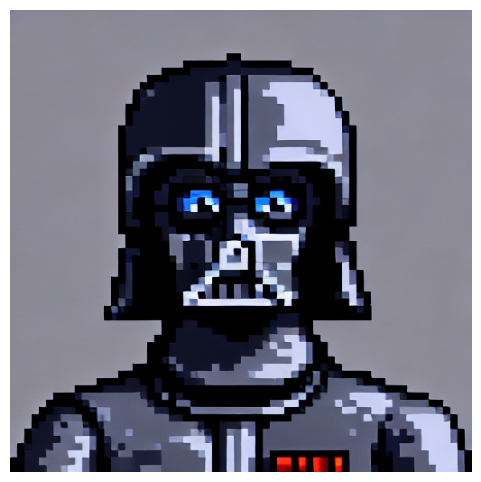

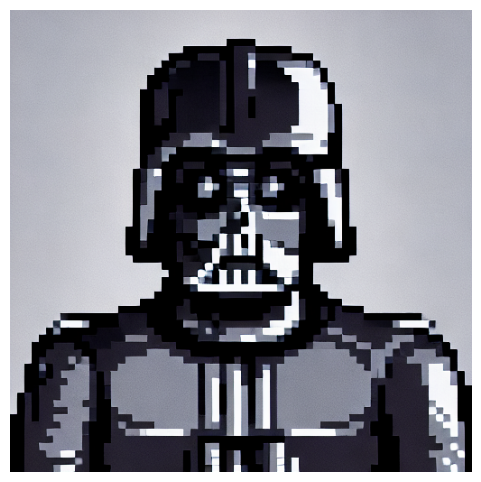

In [ ]:
g1.generate_images(input_prompt="darth vader",
                   num_images=2,           # количество изображений лол (по умолчанию 1)
                   num_inference_steps=50, # "качество картинки", в самой SD по умолчанию 50, тут тоже, но больше 100 ставить не советую, разницы не видно, просто дольше генерируется
                   improve_prompt=False,   # использование GPT для дополнения промта (по умолчанию False)
                   show_prompt=False,)     # выводить ли промт (по умолчанию False)
                   # negative_prompt)      # можно задать свой негативный промт, но по умолчанию он уже введен (можно не трогать)

**А теперь создадим модель для рисунков краской**

In [ ]:
g2 = ImageGenerator(lora_type='ink') # лора с чернилами

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading LoRA weights: madvasik/ink-art-lora


Ink.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

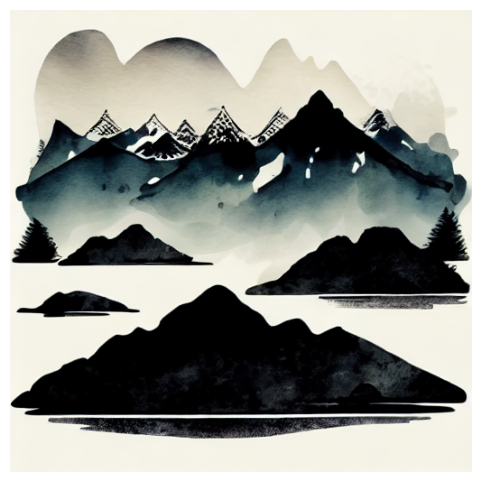

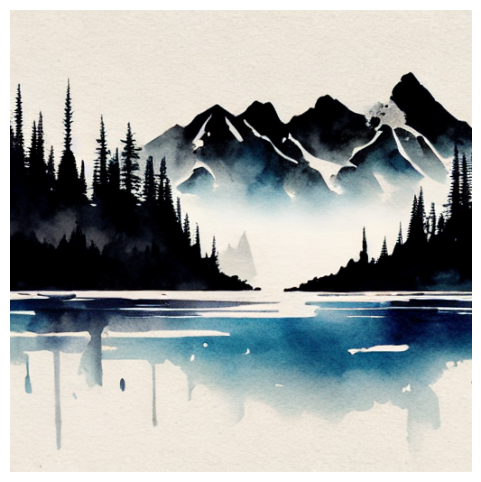

In [ ]:
g2.generate_images(input_prompt="mountains, trees, water",
                   num_images=2,
                   num_inference_steps=50,
                   improve_prompt=False,
                   show_prompt=False)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated prompt: white background, scenery, ink, mountains, trees, waterfalls, foggy atmosphere, stunning sunny lighting, sunrise, vivid colors, in the style of pixar animation, trending on Artstation, 8k, matte painting, ray tracing, hyper detailed, unreal engine 5, cinematic, epic lighting, cryengine, octane render, cyberpunk, red and orange glow


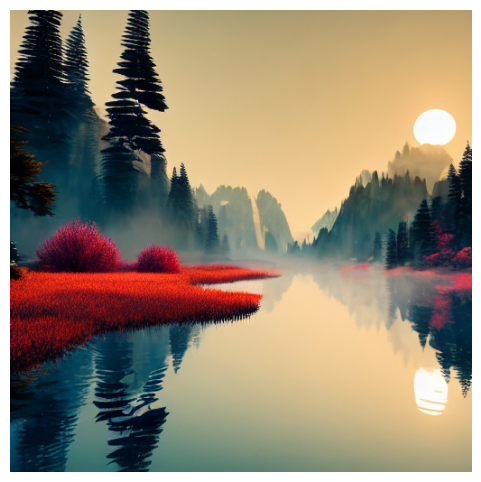

Generated prompt: white background, scenery, ink, mountains, trees, waterfalls, foggy atmosphere, stunning sunny lighting, sunrise, vivid colors, in the style of pixar animation, trending on Artstation, 8k, matte painting, ray tracing, hyper detailed, unreal engine 5, cinematic, epic lighting, cryengine, octane render, cyberpunk, red and orange glow


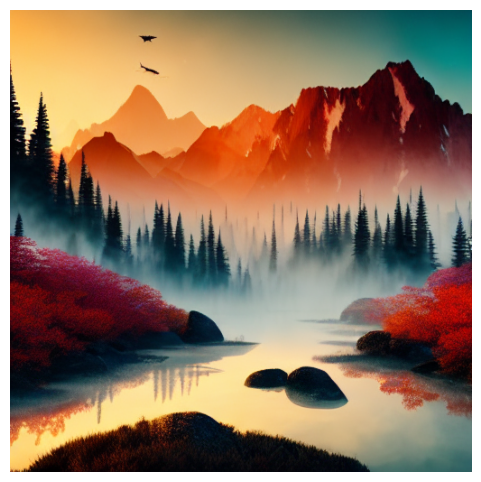

In [ ]:
g2.generate_images(input_prompt="mountains, trees, water",
                   num_images=2,
                   num_inference_steps=50,
                   improve_prompt=True, # а тут гпт используем
                   show_prompt=True)